# k-nearest neighbors


## Import data and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Group Project/depression.csv')
df

## Data preprocessing

### Extract input and output features

In [ ]:
from collections import Counter
X = df
y = df['DASS_depression_severity']

X = X.drop(columns='DASS_depression_severity')

### Oversampling

In [ ]:
print(f"Initial: {Counter(y)}")

Initial: Counter({0: 201, 1: 49, 2: 37, 3: 16, 4: 13})


In [ ]:
from imblearn.over_sampling import RandomOverSampler
over = RandomOverSampler(sampling_strategy={0: 201, 1: 150, 2: 120, 3: 50, 4: 50})
X, y = over.fit_resample(X, y)
print(f"Oversampled: {Counter(y)}")

Oversampled: Counter({0: 201, 1: 150, 2: 120, 3: 50, 4: 50})


### One hot encoding for categorical data

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
X[['Alone','Friends/Coursemates','Family']] = ohe.fit_transform(X['Living_with1'].values.reshape(-1,1))
X[['< RM1000','RM1000 - 3000','> RM3000']] = ohe.fit_transform(X['Expenses'].values.reshape(-1,1))
y = ohe.fit_transform(y.values.reshape(-1,1))

X = X.drop(columns=['Living_with1','Expenses'])
y

### Remove unrelated and inferred features

In [ ]:
print(X.columns)
X.drop(columns=['Code','Residence_high_COVID1','Living_with','Monthly_expenses',
                 'DASS_depression_numerical','DASS_anxiety_numerical','DASS_stress_numerical',
                 'DASS_depression_binary','DASS_anxiety_binary','DASS_anxiety_severity','DASS_stress_binary','DASS_stress_severity'
                 ],
        inplace=True, axis=1)
print(X.columns)

### Feature selection

In [ ]:
X.drop(columns=['Age_Numerical','Class_hours',
                'Gender','Med_or_not','Religion_binary',
                'Worry_family'],
        inplace=True, axis=1)
print(X.columns)

### Split into the training and test set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

### Feature normalisation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def featureNormalisation():
  numeric_data = ['MSPSS_family', 'MSPSS_friends', 'MSPSS_significant_others']

  ct = ColumnTransformer([('scaler', StandardScaler(), numeric_data)], remainder='passthrough')

  X_train_scaled = ct.fit_transform(X_train)
  # print(pd.DataFrame(X_train_scaled, columns = ct.get_feature_names_out()))
  # the test set uses the fitted scaler in train dataset to transform in the test set
  X_test_scaled = ct.transform(X_test)
  return X_train_scaled, X_test_scaled, ct

X_train_scaled, X_test_scaled, ct = featureNormalisation()
features = ct.get_feature_names_out()

## Training model

### Import libraries

In [ ]:
from sklearn import datasets, metrics
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection  import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn

### Hyperparameter tuning (k, weights, P)

1）The hyperparameter k = 5 is selected empirically

In [ ]:
knn = KNN(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)
y_predict = knn.predict(X_test_scaled)
knn_score = metrics.accuracy_score(y_test, y_predict)
knn_score

0.5406976744186046

2) Obtain the optimal hyperparameter K, without considering weights

In [ ]:
best_score = 0.0
best_k = -1

for k in range(1, 30):  # increasing the k value by 1 from 1 to 29
    knn = KNN(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    # knn_score = knn.score(X_test_scaled, y_test)
    y_predict = knn.predict(X_test_scaled)
    knn_score = metrics.accuracy_score(y_test, y_predict)
    if knn_score > best_score:  # compare the accuracy with respected k value
        best_score = knn_score
        best_k = k

print("best_k = ", best_k)
print("best_score = ", best_score)

best_k =  1
best_score =  0.7848837209302325


3) Obtain the optimal hyperparameters k and weight

In [ ]:
best_method = ""
best_score = 0.0
best_k = -1
for method in ["uniform", "distance"]:
    for k in range(1, 30):
        knn = KNN(n_neighbors = k)
        knn.fit(X_train_scaled, y_train)
        y_predict = knn.predict(X_test_scaled)
        knn_score = metrics.accuracy_score(y_test, y_predict)
        if knn_score > best_score:
            best_score = knn_score
            best_k = k
            best_method = method

print("best_method = ", best_method)
print("best_k = ", best_k)
print("best_score = ", best_score)

best_method =  uniform
best_k =  1
best_score =  0.7848837209302325


4) Obtain the optimal hyperparameter k and P (weights must be distance)

In [ ]:
best_p = -1
best_score = 0.0
best_k = -1
for k in range(1, 30):
    for p in range(1, 6):
        knn = KNN(n_neighbors = k, weights = "distance", p = p)
        knn.fit(X_train_scaled, y_train)
        y_predict = knn.predict(X_test_scaled)
        knn_score = metrics.accuracy_score(y_test, y_predict)
        if knn_score > best_score:
            best_score = knn_score
            best_k = k
            best_p = p

print("best_p = ", best_p)
print("best_k = ", best_k)
print("best_score = ", best_score)

best_p =  5
best_k =  1
best_score =  0.813953488372093


In [ ]:
knn = KNN(n_neighbors = 1, weights = "distance", p = 5)
knn.fit(X_train_scaled, y_train)
y_predict = knn.predict(X_test_scaled)
print(metrics.accuracy_score(y_test, y_predict))

0.813953488372093


### Performance metrics

### Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_class = np.argmax(y_predict, axis=1)
y_test_class = np.argmax(y_test, axis=1)

print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.81      0.64      0.72        61
           1       0.77      0.90      0.83        41
           2       0.81      0.91      0.86        43
           3       0.80      0.86      0.83        14
           4       1.00      1.00      1.00        13

    accuracy                           0.81       172
   macro avg       0.84      0.86      0.85       172
weighted avg       0.82      0.81      0.81       172



### Confusion matrix

In [ ]:
cm = confusion_matrix(y_test_class, y_pred_class)
cm

array([[39, 11,  9,  2,  0],
       [ 4, 37,  0,  0,  0],
       [ 3,  0, 39,  1,  0],
       [ 2,  0,  0, 12,  0],
       [ 0,  0,  0,  0, 13]])

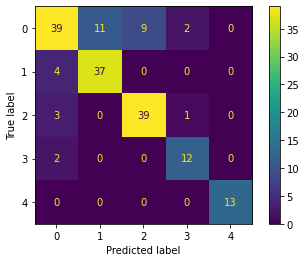

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

### ROC curve

#### Area under the ROC curve

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_predict, multi_class = 'ovo')

0.9052097557651676

#### Plot of ROC curve

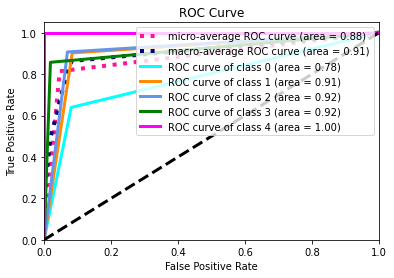

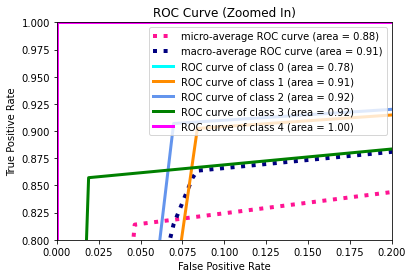

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from numpy import interp
from itertools import cycle

n_classes = 5

# Plot linewidth.
lw = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="upper right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Zoomed In)')
plt.legend(loc="upper right")
plt.show()

## Save model and scaler

In [ ]:
# Save the model as a pickle in a file 
joblib.dump(knn, 'knn_model.pkl') 
  
# Load the model from the file 
knn_from_joblib = joblib.load('knn_model.pkl')  
  
# Use the loaded model to make predictions 
knn_from_joblib.predict(X_test_scaled) 

In [213]:
import joblib
joblib.dump(ct, 'knn_scaler.pkl')

['knn_scaler.pkl']